In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import seaborn as sns
import scipy.optimize as spo
import datetime

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
def get_symbol_path(symbol, base_dir="Udacity/individual_stocks_5yr/individual_stocks_5yr/"):
    return os.path.join(base_dir, "{}_data.csv".format(str(symbol)))

In [3]:
def ingest(symbols, start, end):
    start_date = start
    end_date = end
    dates = pd.date_range(start_date, end_date)
    df1 = pd.DataFrame(index=dates)
    
    for symbol in symbols:
        df_temp = pd.read_csv(get_symbol_path(symbol), index_col='date', parse_dates=True,
                       usecols=['date', 'close'],
                       na_values=['nan'])
        
        df_temp = df_temp.rename(columns={'close':'{}_close'.format(symbol)})
        df1 = df1.join(df_temp, how='inner')
        
    return df1

In [4]:
def plot_data(df, symbols, title="Stock prices"):
    cols = ["{}_close".format(sym) for sym in symbols]
    ax = df[cols].plot(title=title)
    ax.set_xlabel("Dates")
    ax.set_ylabel("Prices")
    plt.show()

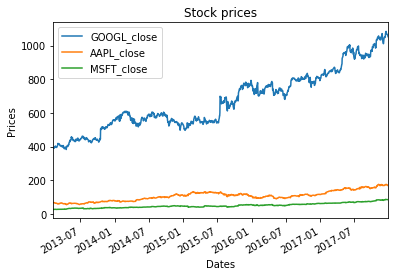

In [5]:
symbols = ['GOOGL', 'AAPL', 'MSFT',]
df = ingest(symbols, '2013-01-01', '2017-12-31')
plot_data(df, symbols)

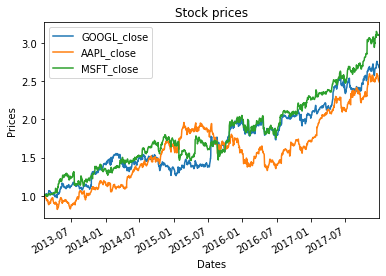

In [7]:
df_temp = df/df.ix[0,:]
plot_data(df_temp, symbols)

### Plot rolling stats

In [8]:
sym = ['GOOGL']
df_GOOGL = ingest(sym, '2016-01-01', '2017-12-31')

In [9]:
def get_rolling_mean(vals, window):
    return vals.rolling(window=window).mean()

def get_rolling_stddev(vals, window):
    return vals.rolling(window=window).std()

def get_bollinger_bands(rm, rstd):
    #Upper band is calculated by measuring two standard deviations above the mean
    upper = rm + (2*rstd)
    
    #Lower band is calculated by measuring two standard deviations below the mean
    lower = rm - (2*rstd)
    
    return upper, lower

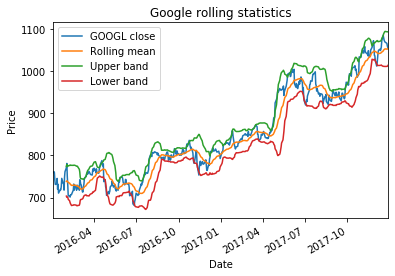

In [10]:
#Plot GOOGL data, and retain matplotlib object
ax = df_GOOGL['GOOGL_close'].plot(title='Google rolling statistics', label='GOOGL close')

#Compute rolling mean for Google closing price for the year 2016, with a 20 day window
rm_GOOGL = get_rolling_mean(df_GOOGL['GOOGL_close'], 20)

#Computer rolling standard deviation
rstd_GOOGL = get_rolling_stddev(df_GOOGL['GOOGL_close'], 20)

#Compute bollinger bands
upper_band, lower_band = get_bollinger_bands(rm_GOOGL, rstd_GOOGL)

#Plot the statistics
rm_GOOGL.plot(label = 'Rolling mean', ax=ax)
upper_band.plot(label = 'Upper band', ax=ax)
lower_band.plot(label = 'Lower band', ax=ax)

#Set legend and axis 
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend(loc='upper left')
plt.show()

### Compute daily returns

In [11]:
def compute_daily_returns(df):
    #Calculate daily returns from index 1
    daily_returns = (df/df.shift(1)) - 1
    
    #Since we do not have data before day 0, set all values at 0th index to 0
    daily_returns.ix[0,:] = 0
    
    '''
    Another way to calculate daily returns:
    1. Make copy of df
    daily_returns = df.copy()
    
    2.Calculate using .values
    daily_returns[1:] = (df/df[:-1].values) - 1
    
    3. Set all values at 0th index to 0
    daily_returns.ix[0,:] = 0
    '''
    return daily_returns

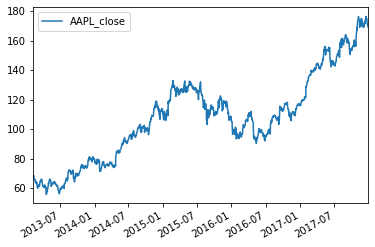

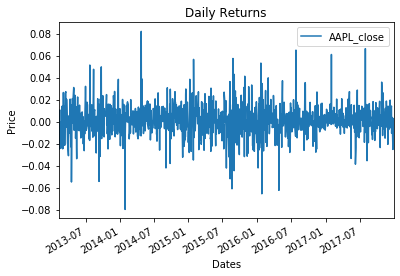

In [12]:
df_daily_returns = ingest(['AAPL'], '2013-01-01', '2017-12-31')
daily_returns = compute_daily_returns(df_daily_returns)

df_daily_returns.plot()
daily_returns.plot()
plt.xlabel('Dates')
plt.ylabel('Price')
plt.title('Daily Returns')
plt.show()

### Plot histograms for daily returns

In [13]:
mean = daily_returns['AAPL_close'].mean()
stddev = daily_returns['AAPL_close'].std()

mean =  0.0008471988854300138
std deviation =  0.014549587701961587


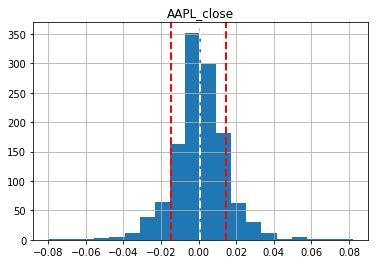

AAPL_close    3.861805
dtype: float64


In [14]:
print("mean = ",mean)
print("std deviation = ",stddev)
daily_returns.hist(bins=20)
plt.axvline(mean, color='w', linestyle='dashed', linewidth=2)
plt.axvline(stddev, color='r', linestyle='dashed', linewidth=2)
plt.axvline(-stddev, color='r', linestyle='dashed', linewidth=2)
plt.show()

#Kurtosis compares the tails of the plot with the tails of a normal distribution 
#If kurtosis is +ve, then the tails of the plot are fatter than a normal distribution
#If kurtosis is -ve, then the tails of the plot are skinnier than a normal distribution
print(daily_returns.kurtosis())

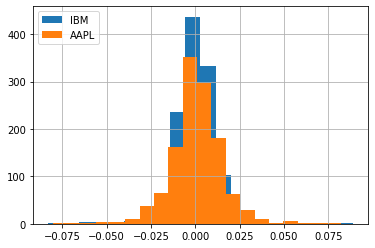

In [15]:
#Daily returns of two or more stocks
df1 = ingest(['AAPL', 'IBM'], '2013-01-01', '2017-12-31')
df1_dreturns = compute_daily_returns(df1)

#Plot
df1_dreturns['IBM_close'].hist(bins=20, label='IBM')
df1_dreturns['AAPL_close'].hist(bins=20, label='AAPL')
plt.legend(loc='upper left')
plt.show()

IBM_close: 8.440117797038937
AAPL_close: 3.861804950529666


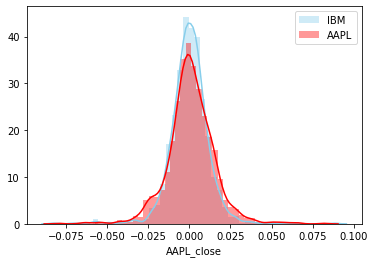

In [16]:
sns.distplot(df1_dreturns['IBM_close'], color='skyblue', label='IBM')
sns.distplot(df1_dreturns['AAPL_close'], color='red', label='AAPL')
plt.legend()
print("IBM_close:",df1_dreturns['IBM_close'].kurtosis())
print("AAPL_close:",df1_dreturns['AAPL_close'].kurtosis())
plt.show()

### Scatter plots for daily returns

Beta_GOOGL = 0.3188392834703044
Alpha_GOOGL = 0.0006227673420359911


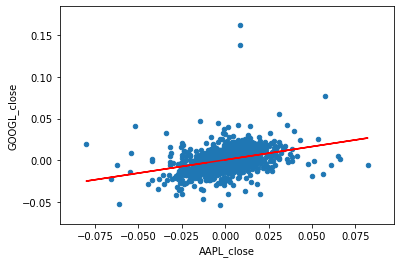

Beta_MSFT = 0.3471121026780582
Alpha_MSFT = 0.0007253578792539681


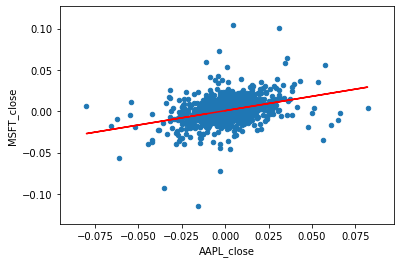

Beta_MSFT = 0.4911807489031607
Alpha_MSFT = 0.0005808616521396901


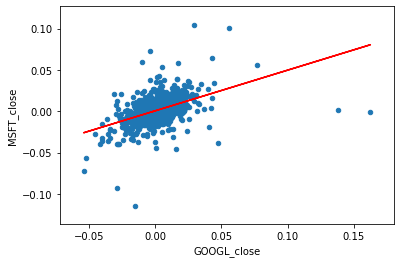

In [17]:
df2 = ingest(['AAPL', 'GOOGL', 'MSFT'], '2013-01-01', '2017-12-31')
df2_dreturns = compute_daily_returns(df2)

#---plot Apple vs Google----#
df2_dreturns.plot(kind='scatter', x='AAPL_close', y='GOOGL_close')
#Get slope and y-intercept using np.polyfit()
beta_GOOGL, alpha_GOOGL = np.polyfit(x=df2_dreturns['AAPL_close'], y=df2_dreturns['GOOGL_close'], deg=1)
print("Beta_GOOGL = {}\nAlpha_GOOGL = {}".format(beta_GOOGL, alpha_GOOGL))
plt.plot(df2_dreturns['AAPL_close'], beta_GOOGL*df2_dreturns['AAPL_close'] + alpha_GOOGL, '-', color='r')
plt.show()

#---plot Apple vs Microsoft---#
df2_dreturns.plot(kind='scatter', x='AAPL_close', y='MSFT_close')
beta_MSFT, alpha_MSFT = np.polyfit(x=df2_dreturns['AAPL_close'], y=df2_dreturns['MSFT_close'], deg=1)
print("Beta_MSFT = {}\nAlpha_MSFT = {}".format(beta_MSFT, alpha_MSFT))
plt.plot(df2_dreturns['AAPL_close'], beta_MSFT*df2_dreturns['AAPL_close'] + alpha_MSFT, '-', color='r')
plt.show()

#---plot Google vs Microsoft---#
df2_dreturns.plot(kind='scatter', x='GOOGL_close', y='MSFT_close')
beta_MSFT, alpha_MSFT = np.polyfit(df2_dreturns['GOOGL_close'], df2_dreturns['MSFT_close'], 1)
print("Beta_MSFT = {}\nAlpha_MSFT = {}".format(beta_MSFT, alpha_MSFT))
plt.plot(df2_dreturns['GOOGL_close'], beta_MSFT*df2_dreturns['GOOGL_close'] + alpha_MSFT, '-', color='r')
plt.show()

In [18]:
#Computing correlation
df2_dreturns.corr(method='pearson')

,AAPL_close,GOOGL_close,MSFT_close
AAPL_close,1.000000,0.336781,0.356693
GOOGL_close,0.336781,1.000000,0.477849
MSFT_close,0.356693,0.477849,1.000000


### Compute cumulative returns

In [19]:
def compute_cumulative_returns(df):
    cumulative_returns = (df/df.ix[0,:]) - 1
    return cumulative_returns

In [20]:
cumulative_returns = compute_cumulative_returns(df_daily_returns)

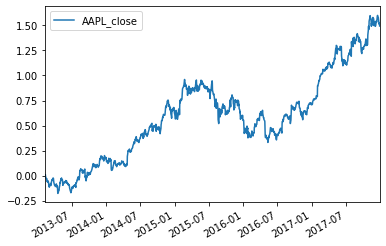

In [21]:
cumulative_returns.plot()
plt.show()

## Daily portfolio value

### SHARPE RATIO:

**Sharpe ratio** is used to determine how good an asset is, based on the daily returns and the volatility or risk of the stock. 
<br>It is calculated using this formula: 
\begin{equation*}
SR = mean(returns - risk free interest)/\sigma{(daily returns)}
\end{equation*}
<br>Sharpe ratio varies based on the samples that you will use i.e whether you are calculating it daily, weekly or monthly.
To accomodate for this change in value, SR needs to be adjusted. The way it is adjusted is by multiplying SR with a term, K.
\begin{equation*}
K = \sqrt{rate of samples}
\end{equation*}
<br>
So, if we are calculating the SR daily, for 252 trading days, K = (252)^(1/2)
Similarly, K = (52)^(1/2) if we are calculating weekly, for 52 weeks and K = (12)^(1/2) if we are calculating monthly for 12 months.
Therefore, the adjusted SR formula becomes 
\begin{equation*}
SR = K \frac{mean(returns - risk free interest)}{\sigma{(daily returns)}}
\end{equation*}

In [53]:
#Start with prices for the given stocks (in this case, we have 4 stocks)
symbols = ['AAPL', 'GOOGL', 'XOM', 'IBM']

#This list has the percentages of funds to be allocated to each stock
#40% of our starting value goes to AAPL, another 40% goes to GOOGL, 10% to XOM and 10% to IBM
allocations = [0.25, 0.25, 0.25, 0.25]

#The funds that we start with
start_val = 1000000

#Dataframe with all the stocks and corresponding prices for the years 2014-2016
df_2013 = ingest(symbols, '2013-01-01', '2013-12-31')
df_2014 = ingest(symbols, '2014-01-01', '2014-12-31')
df_2015 = ingest(symbols, '2015-01-01', '2015-12-31')
df_2016 = ingest(symbols, '2016-01-01', '2016-12-31')
df_2017 = ingest(symbols, '2017-01-01', '2017-12-31')

In [54]:
def data_prep(allocations, data, start_val):
    #Normalization
    data_normed = data/data.ix[0,:]
    
    #multiply by given allocations
    alloced = pd.DataFrame()
    for i in range(data_normed.shape[1]):
        alloced[data_normed.columns[i]] = data_normed.ix[:,i]*allocations[i]
        
    position_values = alloced*start_val
    
    portfolio_vals = position_values.sum(axis=1)
    
    return portfolio_vals

In [117]:
def portfolio_stats(portfolio, allocations, start_val, optimized=False):
    portfolio_vals = data_prep(allocations, portfolio, start_val)
    
    #Compute daily returns on the porfolio_val
    portfolio_dr = (portfolio_vals/portfolio_vals.shift(1)) - 1
    #Take values from the second day, as there will be no change of price on the first day 
    portfolio_dr = portfolio_dr[1:]
    
    #Plot statistics
#     if optimized == False:
#         portfolio_vals.plot(title=portfolio.index[0].year, label=str(portfolio.index[0].year) + 'before optimization')
#     else:
#         portfolio_vals.plot(title=portfolio.index[0].year, label=str(portfolio.index[0].year) + 'after optimization')
#     plt.xlabel('Dates')
#     plt.ylabel('Returns')
#     plt.legend()
    
    #---Portfolio Statistics---#
    #Cumulative returns
    #Compare the value of portfolio on last day to first day
    cum_returns = (portfolio_vals[-1]/portfolio_vals[0])-1
    
    #Average daily returns
    avg_returns = portfolio_dr.mean()

    #Standard daily returns
    std_returns = portfolio_dr.std()
    
    k = 252 #No. of trading days
    sr = (k**(1/2))*(portfolio_dr.mean()/portfolio_dr.std())
    
    print("\nCumulative returns: {}\nAverage returns: {}\nStandard returns: {}\nSharpe Ratio: {}\n".
          format(cum_returns, avg_returns, std_returns, sr))
    
    return sr

In [56]:
def sharpe_ratio_optimization(allocations, data, start_val):
    portfolio_vals = data_prep(allocations, data, start_val)
    portfolio_dr = (portfolio_vals/portfolio_vals.shift(1)) - 1
    portfolio_dr = portfolio_dr[1:]
    
    k = 252 #No. of trading days
    sr = (k**(1/2))*(portfolio_dr.mean()/portfolio_dr.std())
    
    return -(sr)

In [103]:
def optimizer(fn, init_alloc, data, start_val):
    bnds = ((0,1), (0,1), (0,1), (0,1))
    constraints = {'type':'eq', 'fun':con}
    fit = spo.minimize(fn, init_alloc, args=(data, start_val,), method='SLSQP', 
                       bounds=bnds, constraints=constraints, options={'disp':False})
#     print(fit.x)
    return fit.x

In [58]:
def con(c):
    return c.sum() - 1

In [128]:
def portfolio_over_5_years():
    df = (df_2013, df_2014, df_2015, df_2016, df_2017)
    allocation = [0.25, 0.25, 0.25, 0.25]
    start_val = 1000000
    sr_before = []
    sr_after = []
    years = [data.index[0].year for data in df]
    for data in df:
        print("At the start of year {}, the designated allocations for ${} are:".format(data.index[0].year, start_val))
        print("{}% for {}, {}% for {}, {}% for {} and {}% for {}".
              format(round(allocation[0]*100, 2), data.columns[0],
                    round(allocation[1]*100, 2), data.columns[1],
                    round(allocation[2]*100, 2), data.columns[2],
                    round(allocation[3]*100, 2), data.columns[3],))
        sr_before.append(portfolio_stats(data, allocation, start_val))
        optimized_alloc = optimizer(sharpe_ratio_optimization, allocation, data, start_val)
        allocation = optimized_alloc
        print("At the end of year {}, the designated allocations for ${} are:".format(data.index[0].year, start_val))
        print("{}% for {}, {}% for {}, {}% for {} and {}% for {}".
              format(round(allocation[0]*100, 2), data.columns[0],
                    round(allocation[1]*100, 2), data.columns[1],
                    round(allocation[2]*100, 2), data.columns[2],
                    round(allocation[3]*100, 2), data.columns[3],))
        sr_after.append(portfolio_stats(data, allocation, start_val, optimized=True))
        
    plt.plot(years, sr_before, label="Before optimization", color='blue')
    plt.plot(years, sr_before, 'o', color='green')
    plt.plot(years, sr_after, label="After optimization", color='red')
    plt.plot(years, sr_after, 'o', color='green')
    plt.xlabel("Dates")
    plt.ylabel("Sharpe Ratio")
    plt.legend()
    plt.show()

At the start of year 2013, the designated allocations for $1000000 are:
25.0% for AAPL_close, 25.0% for GOOGL_close, 25.0% for XOM_close and 25.0% for IBM_close

Cumulative returns: 0.17006219170394865
Average returns: 0.000727249154620976
Standard returns: 0.007639359294410616
Sharpe Ratio: 1.5112160563388009

At the end of year 2013, the designated allocations for $1000000 are:
14.24% for AAPL_close, 49.87% for GOOGL_close, 35.89% for XOM_close and 0.0% for IBM_close

Cumulative returns: 0.289721027981688
Average returns: 0.0011702356310892166
Standard returns: 0.008896602709115197
Sharpe Ratio: 2.08809085205293

At the start of year 2014, the designated allocations for $1000000 are:
14.24% for AAPL_close, 49.87% for GOOGL_close, 35.89% for XOM_close and 0.0% for IBM_close

Cumulative returns: 0.0065894220656901314
Average returns: 7.020384325571313e-05
Standard returns: 0.009391415444015368
Sharpe Ratio: 0.11866703892048933

At the end of year 2014, the designated allocations for $1

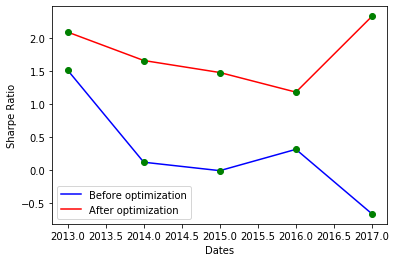

In [129]:
portfolio_over_5_years()

### Minimization

In [ ]:
def f(x):
    y = (x-1.5)**2 + 0.5
    return y

In [ ]:
def minimize():
    x_guess = 2.0
    min_res = spo.minimize(f, x_guess, method='SLSQP', options={'disp':True})
    print("Minima found at:")
    print("X = {}, y = {}".format(min_res.x, min_res.fun))
    Xplot = np.linspace(0.5, 2.5, 20)
    Yplot = f(Xplot)
    plt.plot(Xplot, Yplot)
    plt.plot(min_res.x, min_res.fun, 'ro', color='red')
    plt.show()
    
    

In [ ]:
minimize()

In [ ]:
def error(line, data):
    '''
    line contains slope and y-intercept: line[0] is slope, line[1] is y-intercept
    data contains the data points that we want to plot. We are plotting Apple daily returns,
    against Google daily returns. 
    '''
    err = np.sum((data[:,1] - (line[0]*data[:,0] + line[1]))**2)
    return err

In [ ]:
def fit_line(data, error):
    #initial guess
    init = np.float32([0, np.mean(data[:, 1])])
    
    #call optimizer to minimize the error
    minima = spo.minimize(error, init, args=(data,), method='SLSQP', options={'disp':True})
    return minima.x

In [ ]:
def test():
    #original line
    l_orig = np.float32([4, 3])
    Xorig = np.linspace(0, 10, 21)
    Yorig = l_orig[0]*Xorig + l_orig[1]
    plt.plot(Xorig, Yorig, 'b--', linewidth=2.0, label='Original line')
    
    #noisy data
    noise_sigma = 3.0
    noise = np.random.normal(0, noise_sigma, Yorig.shape)
    data = np.asarray([Xorig, Yorig + noise]).T
    plt.plot(data[:,0], data[:,1], 'go', label='Data points')
    
    #Fit line with this data
    l_fit = fit_line(data, error)
    print("Slope = {}, Intercept = {}".format(l_fit[0], l_fit[1]))
    plt.plot(data[:,0], l_fit[0]*data[:,0] + l_fit[1], 'r--', linewidth=2.0, label='Fitted line')

In [ ]:
def test_poly():
    x = np.linspace(-5, 5, 21)
    coeff = np.float32([0.4, 0.4, 0.1, 0.1])
    C = np.poly1d(coeff)
    y = np.polyval(C, x)
    plt.plot(x, y, 'b--',linewidth=2.0, label='Original Line')
    print(C)
    
    #noise
    noise_sigma = 3.0
    noise = np.random.normal(0, noise_sigma, y.shape)
    data = np.asarray([x, y+noise]).T
    print(data.shape)
    plt.plot(data[:,0], data[:,1], 'go', label='Data points')
    
    #fit line
    l_fit = fit_poly(data, err_poly)
    plt.plot(data[:,0], np.polyval(l_fit, data[:,0]), 'r--')

In [ ]:
def err_poly(C, data):
#     print("Err",data)
#     print("Err", C)
    err = np.sum((data[:,1] - np.polyval(C, data[:,0]))**2)
    return err

In [ ]:
def fit_poly(data, error):
    init = np.poly1d(np.ones(4, dtype=np.float32))
#     print("Fit poly", data)
#     print("Fit poly",init)
    res = spo.minimize(error, init, args=(data, ), method='SLSQP', options={'disp':True})
    return np.poly1d(res.x)

In [ ]:
test_poly()